In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D
from keras.optimizers import SGD
from numpy.random import uniform
import keras
from tensorflow.keras import layers

In [ ]:
def generate_mixed_shape(shape1, shape2, shape3, shape4):
    shape = []
    shape.extend(shape1[:15].tolist())
    shape.extend(shape2[15:30].tolist())
    shape.extend(shape3[30:45].tolist())
    shape.extend(shape4[45:60].tolist())
    return pd.DataFrame([shape])

In [ ]:
def generate_noisy_shape(shape):
    noisyShape = []
    for val in shape:
        noisyShape.append(val + uniform(-0.3, 0.3))
    return pd.DataFrame([noisyShape])

In [ ]:
symbol_data = pd.read_csv("data/3DMaster_dataset_fixed.csv", header=None)
#symbol_data = pd.read_csv("data/dataset1_fixed.csv", header=None)
X = symbol_data.iloc[:, :-1]
Y = symbol_data.iloc[:, -1:]
Y = Y.replace("Time", 0)
Y = Y.replace("Air", 1)
Y = Y.replace("Fire", 2)
#Y = Y.replace("Earth", 3)
#Y = Y.replace("Water", 4)
Y = Y.replace("Lightning", 3) #cant have empty entries this must be 3
print(Y)
print(X)
for i in range(500):
    random_symbols = X.sample(n=4)
    X = pd.concat([X, generate_mixed_shape(random_symbols.iloc[0], random_symbols.iloc[1], random_symbols.iloc[2], random_symbols.iloc[3])])
    Y = pd.concat([Y, pd.DataFrame([3], columns=[60])])

for i in range(500):
    random_symbol = X.sample(n=1)
    X = pd.concat([X, pd.DataFrame(generate_noisy_shape(random_symbol.iloc[0]))])
    Y = pd.concat([Y, pd.DataFrame([3], columns=[60])])

x_train, x_test, y_train, y_test = train_test_split(np.array(X), Y, test_size=0.20)

y_test = y_test.values.flatten().astype("float64")
y_train = y_train.values.flatten().astype("float64")

In [ ]:
x_train_3d = [np.array(x_train[i]).reshape(-1, 3) for i in range(len(x_train))]
x_test_3d = [np.array(x_test[i]).reshape(-1, 3) for i in range(len(x_test))]

x_train_3d = tf.stack(x_train_3d)
x_test_3d = tf.stack(x_test_3d)

In [ ]:
print(x_test_3d)

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
points = x_train_3d[4]
clas = y_train[4]
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
ax.view_init(elev=90, azim=0, roll=90)
plt.show()
print("label: ", clas)

In [ ]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

In [ ]:
NUM_POINTS = 20
NUM_CLASSES = 5
BATCH_SIZE = 32

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_3d, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_3d, y_test))

train_dataset = train_dataset.shuffle(len(x_train_3d)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
train_dataset

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
class OrthogonalRegularizerTest(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

    def get_config(self):
        return {'num_features': float(self.num_features), 'l2reg': float(self.l2reg)}

In [ ]:
def tnet(inputs, num_features, subfix):
    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    # reg = tf.keras.regularizers.OrthogonalRegularizer(factor=0.01, mode="columns")
    # reg = tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
    reg = OrthogonalRegularizerTest(num_features)

    x = conv_bn(inputs, 32, subfix + "_1")
    x = conv_bn(x, 64, subfix + "_2")
    x = conv_bn(x, 512, subfix + "_3")
    x = layers.GlobalMaxPooling1D(name="maxpool_" + subfix)(x)
    x = dense_bn(x, 256, subfix + "_4")
    x = dense_bn(x, 256, subfix + "_5")
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
        name="T_" + subfix,
    )(x)
    feat_T = layers.Reshape((num_features, num_features), name="T_reshape_" + subfix)(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1), name="T_dot_" + subfix)([inputs, feat_T])

In [ ]:
def conv_bn(x, filters, subfix):
    res = x
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name="conv_" + subfix)(x)
    x = layers.BatchNormalization(momentum=0.0, name="bn_" + subfix)(x)
    if res.type_spec.shape == x.type_spec.shape:
        #print(subfix)
        x =layers.Add()([x,res])
    return layers.Activation("relu", name="relu_" + subfix)(x)


def dense_bn(x, filters, subfix):
    res = x
    x = layers.Dense(filters, name="dense_" + subfix)(x)
    x = layers.BatchNormalization(momentum=0.0, name="bn_" + subfix)(x)
    if res.type_spec.shape == x.type_spec.shape:
        #print(subfix)
        x = layers.Add()([x,res])
    return layers.Activation("relu", name="relu_" + subfix)(x)

In [ ]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

embed_dim = 3  # Embedding size for each token
num_heads = 3  # Number of attention heads
ff_dim = 516  # Hidden layer size in feed forward network inside transformer

x = transformer_encoder(inputs, embed_dim, num_heads, ff_dim)
x = tnet(x, 3, "tnet1")
x = conv_bn(x, 32, "1")
x = conv_bn(x, 32,  "2")
x = tnet(x, 32, "tnet2")
x = conv_bn(x, 64, "3")
x = conv_bn(x, 64, "4")
x = conv_bn(x, 512, "5")
x = layers.GlobalMaxPooling1D(name="maxpool1")(x)
x = dense_bn(x, 256, "6")
#x = layers.Dropout(0.3)(x)
x = dense_bn(x, 256, "7")
#x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="outputs")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")

In [ ]:
model.summary()

In [136]:
filepath = "best_model_test"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=500, validation_data=test_dataset, callbacks=callbacks_list)

INFO:tensorflow:Assets written to: best_model_test\assets


INFO:tensorflow:Assets written to: best_model_test\assets


35/35 [==============================] - 7s 214ms/step - loss: 1.3449 - sparse_categorical_accuracy: 0.9406 - val_loss: 1.3271 - val_sparse_categorical_accuracy: 0.9317
Epoch 6/500
34/35 [============================>.] - ETA: 0s - loss: 1.3002 - sparse_categorical_accuracy: 0.9467
Epoch 6: val_sparse_categorical_accuracy did not improve from 0.93165
35/35 [==============================] - 1s 24ms/step - loss: 1.2923 - sparse_categorical_accuracy: 0.9469 - val_loss: 1.4895 - val_sparse_categorical_accuracy: 0.9029
Epoch 7/500
 7/35 [=====>........................] - ETA: 0s - loss: 1.3255 - sparse_categorical_accuracy: 0.9420

In [24]:
model = tf.keras.models.load_model('best_model_test', custom_objects={"OrthogonalRegularizerTest": OrthogonalRegularizerTest})
model.summary()

RuntimeError: Unable to restore object of class 'Dense' likely due to name conflict with built-in Keras class '<class 'keras.layers.core.dense.Dense'>'. To override the built-in Keras definition of the object, decorate your class with `@keras.utils.register_keras_serializable` and include that file in your program, or pass your class in a `keras.utils.CustomObjectScope` that wraps this load call.

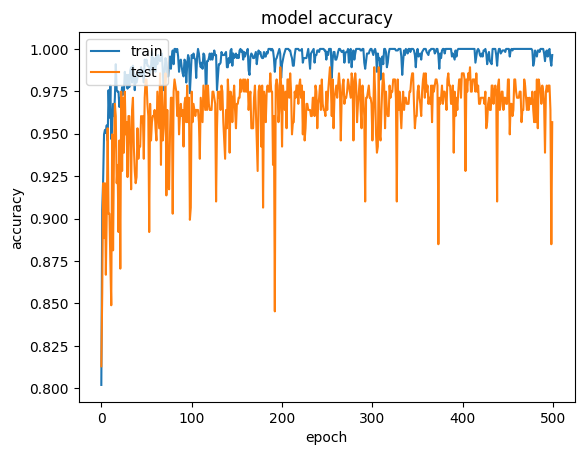

In [25]:
# show history plot
plt.plot(model.history.history["sparse_categorical_accuracy"])
plt.plot(model.history.history["val_sparse_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

9/9 [==============================] - 1s 6ms/step
[[ 12   0   0   0]
 [  0  20   0   4]
 [  0   0  28   4]
 [  2   1   1 206]]


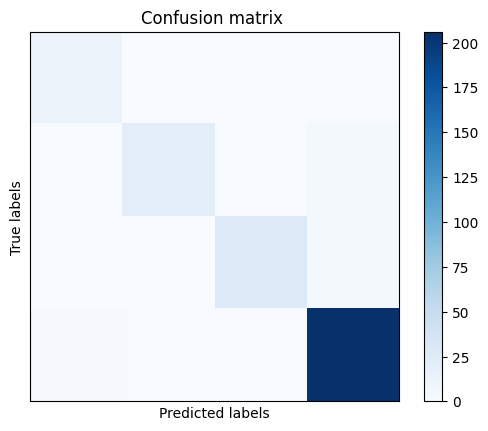

In [26]:
from sklearn.metrics import confusion_matrix

# confusion matrix
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
cm = confusion_matrix(y_true, y_pred)
#cm = [c[0:-1] for c in cm[0:-1]]
print(cm)
# plot
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title("Confusion matrix ")
plt.colorbar()
plt.show()

1/1 [==============================] - 0s 17ms/step


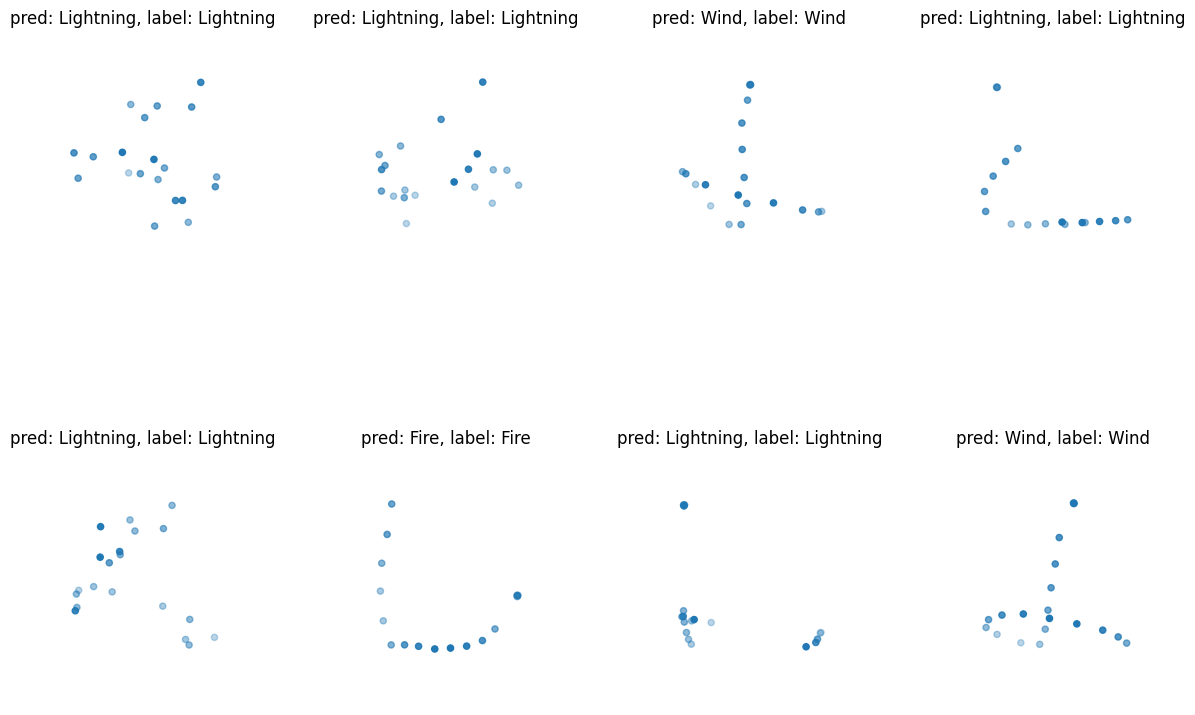

In [30]:
class_map = {}
class_map[0] = "Time"
class_map[1] = "Wind"
class_map[2] = "Fire"
class_map[3] = "Lightning"
class_map[4] = "Other"
#class_map[5] = "Lightning"
#class_map[6] = "Other"

data = train_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            class_map[preds[i].numpy()], class_map[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
    ax.view_init(elev=90, azim=0, roll=90)
plt.show()


In [ ]:
# save with custom objects
model.save('model_3dmaster_with_other_transformer')

model.save('model_3dmaster_with_other_transformer.h5', save_format='h5')

In [28]:
model.evaluate(test_dataset)

9/9 [==============================] - 0s 6ms/step - loss: 1.4555 - sparse_categorical_accuracy: 0.9568


[1.455452561378479, 0.9568345546722412]

In [ ]:
!python -m tf2onnx.convert --saved-model best_model_test --output model_3dmaster_with_other_transformer.onnx

In [ ]:
test_model = keras.models.load_model('model_3dmaster_with_other_transformer', custom_objects={"OrthogonalRegularizerTest": OrthogonalRegularizerTest})